# Computational Assignment 1

This file provides a walk-through of some of the analysis methods that could have been used in the assignment.

I also highlight some code patterns that might help you in future assignments.


## Data

### FRED Data

* Import the data
* Convert missing values to `NaN` using `to_numeric`
* Construct cross-rates
    * *Note*: The Japanese rate is Dollar/Yen by convention. The other are Foreign/Dollar.
    
#### Remarks
1. Reading data with `parse_dates=True` and the `index_col` set parses the dates and sets them as the index.  This is usually a good idea.
2. `pd.to_numeric` can be used to convert a `Series` with strange missing value markerts to `NaN`.  

In [1]:
import pandas as pd

uk = pd.read_csv("DEXUSUK.csv", index_col="DATE", parse_dates=True).iloc[:, 0]
jp = pd.read_csv("DEXJPUS.csv", index_col="DATE", parse_dates=True).iloc[:, 0]
ch = pd.read_csv("DEXSZUS.csv", index_col="DATE", parse_dates=True).iloc[:, 0]
au = pd.read_csv("DEXUSAL.csv", index_col="DATE", parse_dates=True).iloc[:, 0]

uk = pd.to_numeric(uk, errors="coerce")
ch = pd.to_numeric(ch, errors="coerce")
au = pd.to_numeric(au, errors="coerce")
jp = pd.to_numeric(jp, errors="coerce")

jpuk = jp * uk
auch = au / ch
jpuk.name = "JPUK"
auch.name = "AUCH"

### French Data

The CSV files were cleaned prior to import.

#### Remarks
1. `pd.to_datetime` is a simple way to convert string or integer dates to pandas dates.  The `format` argument [accepts many different styles](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes).  The most important are

    * `%Y`: 4-digit year
    * `%m`: 2-digit month
    * `%d` : 2-digit day
    

In [2]:
factors = pd.read_csv("ff-factors.csv")
factors["Date"] = pd.to_datetime(factors.Date, format="%Y%m%d")
mom = pd.read_csv("ff-momentum.csv")
mom["Date"] = pd.to_datetime(mom.Date, format="%Y%m%d")
factors = factors.set_index("Date")
mom = mom.set_index("Date")
ff_returns = pd.concat([factors, mom], axis=1)

# Add RF back to VWM, optional
# ff_returns["Mkt-RF"] = ff_returns["Mkt-RF"] + ff_returns["RF"].values

# Price index construction
ff = (1 + ff_returns / 100).cumprod()
ff.columns = ["vwm", "smb", "hml", "rf", "mom"]
ff = ff[["vwm", "smb", "hml", "rf", "mom"]]

### Yahoo Data

The data was downloaded for the maximum period available.

In [3]:
kospi = pd.read_csv("^KS11.csv", index_col="Date", parse_dates=True)["Adj Close"]
bvsp = pd.read_csv("^BVSP.csv", index_col="Date", parse_dates=True)["Adj Close"]
dax = pd.read_csv("^GDAXI.csv", index_col="Date", parse_dates=True)["Adj Close"]
bond_fund = pd.read_csv("VBTLX.csv", index_col="Date", parse_dates=True)["Adj Close"]
kospi.name = "KOSPI"
bvsp.name = "BVSP"
dax.name = "DAX"
bond_fund.name = "bonds"

### Merge Data

Here I combine all series into a DataFrame which will let me loop over columns easily.

#### Remarks
1. String dates of the form "YYYY", "YYYY-mm", "YYYY-mm-dd" can be used to slice pandas `Series` and `DataFrame`s that have `DatetimeIndex` indices. The slice includes all values in the range, including the end points.  For example, `[:"2019"]` includes all data up-to-and-including December 31, 2019. 
2. Merging data can simplify repeated tasks since it is possible to loop over the columns in a `DataFrame` using the syntax:
```python
for col in df:
    one_column = f[col]
    # do something useful with the columns
```

In [4]:
combined = pd.concat([ff, kospi, bvsp, dax, jpuk, auch, bond_fund], axis=1)
combined = combined[:"2019"]
combined.tail()

,vwm,smb,hml,rf,mom,KOSPI,BVSP,DAX,JPUK,AUCH,bonds
2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,359.871254,1.923631,29.302372,21.155412,339.782285,2197.929932,117203.0,NaN,142.647769,0.707484,10.824861
2019-12-27,359.511383,1.913628,29.281861,21.156893,341.039479,2204.209961,116534.0,13337.110352,143.296230,0.716354,10.834646
2019-12-30,357.462168,1.916882,29.457552,21.158374,341.175895,2197.669922,115964.0,13249.009766,143.028900,0.723778,10.834646
2019-12-31,358.463062,1.916690,29.495846,21.159855,339.538251,NaN,NaN,NaN,144.194223,0.726465,10.839552


# `summary_statistics`

One of the required function for the autograder is presented below. I build a `DataFrame` from `Series`.

#### Remarks
1. Dictionaries (i.e., `d = {}`) are important for writing efficient code. They are also easy to convert to pandas `Series` and dictionaries of `Series` can be easily converted in `DataFrames`.  This is exactly how I build the `DataFrame` below. Dictionaries can also be looped over using the same syntax as a `DataFrame`:
```python
d = {"a": 1, "b": 2, "c": 3}
for key in d:
    value = d[key]
    # do something useful
```

In [5]:
import numpy as np


def summary_statistics(prices):
    prices = prices.dropna()
    values = {}
    # A better approach to scale would be to use a dictionary
    scales = {"D": 252, "W-FRI": 52, "M": 12, "Q": 4, "A": 1}
    for freq in ("D", "W-FRI", "M", "Q", "A"):
        resample = prices.resample(freq).last()
        returns = resample.dropna().pct_change().dropna()
        # The better approack
        # scale = scaled[freq]
        if freq == "D":
            scale = 252
        elif freq == "W-FRI":
            scale = 52
        elif freq == "M":
            scale = 12
        elif freq == "Q":
            scale = 4
        else:
            scale = 1
        # A dictionary to convert to a Series
        moments = {
            "mean": scale * returns.mean(),
            "std": np.sqrt(scale) * returns.std(),
            "skew": returns.skew(),
            "kurt": returns.kurt() + 3,
        }
        # Store the Series in another dictionary.
        values[freq] = pd.Series(moments)
    all_freq = pd.DataFrame(values)
    all_freq.columns = ["Daily", "Weekly", "Monthly", "Quarterly", "Annual"]
    return all_freq


summary_statistics(combined.vwm)

,Daily,Weekly,Monthly,Quarterly,Annual
mean,0.074359,0.077469,0.079803,0.085298,0.083965
std,0.168455,0.171430,0.184345,0.220219,0.198535
skew,-0.120938,-0.358674,0.193515,1.832394,-0.303247
kurt,19.633944,9.156717,10.997113,20.132500,3.048339


Here I collect all of the analyses into groups by frequency by storing them a dictionary

In [6]:
def group_by_freq(prices, series):
    # Empty dictionary where each will hold another dictionary
    grouped = {}
    for col in series:
        temp = summary_statistics(prices[col])
        for freq in temp:
            single = temp[freq]
            # Check if the key exists, if not, create it with an empty dictionary
            if freq not in grouped:
                grouped[freq] = {}
            # Store the Series as an element in the grouped[freq] dictionary
            grouped[freq][col] = single
    for col in grouped:
        # Convert each inner dictionary to a DataFrame
        grouped[col] = pd.DataFrame(grouped[col])
    return grouped


by_freq = group_by_freq(
    combined,
    ["vwm", "smb", "hml", "mom", "DAX", "BVSP", "KOSPI", "AUCH", "JPUK", "bonds"],
)

by_freq["Daily"]

,vwm,smb,hml,mom,DAX,BVSP,KOSPI,AUCH,JPUK,bonds
mean,0.074359,0.010963,0.038946,0.066841,0.104627,0.385818,0.085484,0.036962,-0.029825,0.037948
std,0.168455,0.092420,0.092934,0.118254,0.219834,0.355286,0.271989,0.177073,0.115650,0.039202
skew,-0.120938,-0.754706,0.731388,-1.594806,-0.081570,0.950318,-0.025284,-0.041135,-0.780582,0.075773
kurt,19.633944,25.690942,18.768387,29.870722,8.797502,17.768665,8.892787,21.146994,14.505053,4.367833


In [7]:
by_freq["Monthly"]

,vwm,smb,hml,mom,DAX,BVSP,KOSPI,AUCH,JPUK,bonds
mean,0.079803,0.012764,0.043009,0.074526,0.101791,0.404131,0.086443,0.037605,-0.029404,0.038846
std,0.184345,0.106450,0.114842,0.151961,0.202885,0.437562,0.276574,0.182923,0.118606,0.034419
skew,0.193515,1.122333,1.292989,-0.916640,-0.520413,2.298289,0.851238,0.116887,-0.610010,-0.206248
kurt,10.997113,13.697603,12.403212,11.418075,5.104647,15.307200,8.567472,5.804064,5.584841,4.494305


In [8]:
by_freq["Annual"]

,vwm,smb,hml,mom,DAX,BVSP,KOSPI,AUCH,JPUK,bonds
mean,0.083965,0.014387,0.044961,0.077053,0.111510,0.607236,0.128481,0.033919,-0.025877,0.040159
std,0.198535,0.117578,0.130961,0.154629,0.233566,2.082155,0.311787,0.185100,0.135514,0.028089
skew,-0.303247,0.229972,0.359051,-0.733467,-0.685109,4.759770,0.112506,0.568858,0.288654,-0.432868
kurt,3.048339,4.313512,3.563743,5.582957,2.961143,26.549166,3.370362,2.423933,3.896373,3.017251


There is another way to do the same, which is to use a `MultiIndex` where we have to levels to the index, freq and col.

In [9]:
all_stats = []
for col in ["vwm", "smb", "hml", "mom", "DAX", "BVSP", "KOSPI", "AUCH", "JPUK", "bonds"]:
    stats = summary_statistics(combined[col])
    stats.columns = pd.MultiIndex.from_tuples([(freq,col) for freq in stats])
    all_stats.append(stats)
all_stats = pd.concat(all_stats,1)
all_stats.loc[:,"Daily"]

,vwm,smb,hml,mom,DAX,BVSP,KOSPI,AUCH,JPUK,bonds
mean,0.074359,0.010963,0.038946,0.066841,0.104627,0.385818,0.085484,0.036962,-0.029825,0.037948
std,0.168455,0.092420,0.092934,0.118254,0.219834,0.355286,0.271989,0.177073,0.115650,0.039202
skew,-0.120938,-0.754706,0.731388,-1.594806,-0.081570,0.950318,-0.025284,-0.041135,-0.780582,0.075773
kurt,19.633944,25.690942,18.768387,29.870722,8.797502,17.768665,8.892787,21.146994,14.505053,4.367833


In [10]:
all_stats.loc[:,"Weekly"]

,vwm,smb,hml,mom,DAX,BVSP,KOSPI,AUCH,JPUK,bonds
mean,0.077469,0.011146,0.041316,0.071878,0.102941,0.378262,0.082640,0.036648,-0.028877,0.038887
std,0.171430,0.091119,0.102372,0.137378,0.211765,0.351635,0.270248,0.176249,0.121044,0.037188
skew,-0.358674,0.084792,1.102395,-1.389963,-0.350936,0.632277,-0.144330,-0.093208,-0.925644,-0.396488
kurt,9.156717,13.159411,16.190505,15.522252,6.880258,7.520713,8.057720,9.060139,11.877077,4.108810


I look at monthly stats for each decade.  One could look at other sampling frequencies or decade definitions.

#### Remarks
1. I use a property of pandas Series and DataFrames that have `DatetimeIndex` that let blocks be selected using string dates, e.g., `data["1950":"1959"]` which selects all data with years in 1950 to 1959, inclusive.  

In [11]:
def monthly_stats(prices, decade_starts):
    values = {}
    for decade_start in decade_starts:
        sub = prices[str(decade_start) : str(decade_start + 9)]
        values[decade_start] = summary_statistics(sub)["Monthly"]
    return pd.DataFrame(values)


monthly_stats(combined.vwm, np.arange(1930, 2020, 10))

,1930,1940,1950,1960,1970,1980,1990,2000,2010
mean,0.050890,0.102658,0.156654,0.056932,0.019354,0.079837,0.136544,-0.012911,0.135590
std,0.363584,0.154697,0.112423,0.124866,0.167957,0.167989,0.135518,0.166490,0.129452
skew,0.731872,-1.331744,-0.279851,-0.264714,0.051208,-0.911132,-0.792294,-0.636636,-0.395563
kurt,5.819518,7.632213,2.574932,3.379399,4.018050,7.345798,5.471178,3.689987,3.645049


There are many ways to compare the statistics.  I have plotted the statistics in all year 10-year blocks (i.e., 1930-1939, 1931-1940, ...) and the long-run value of the statistic.

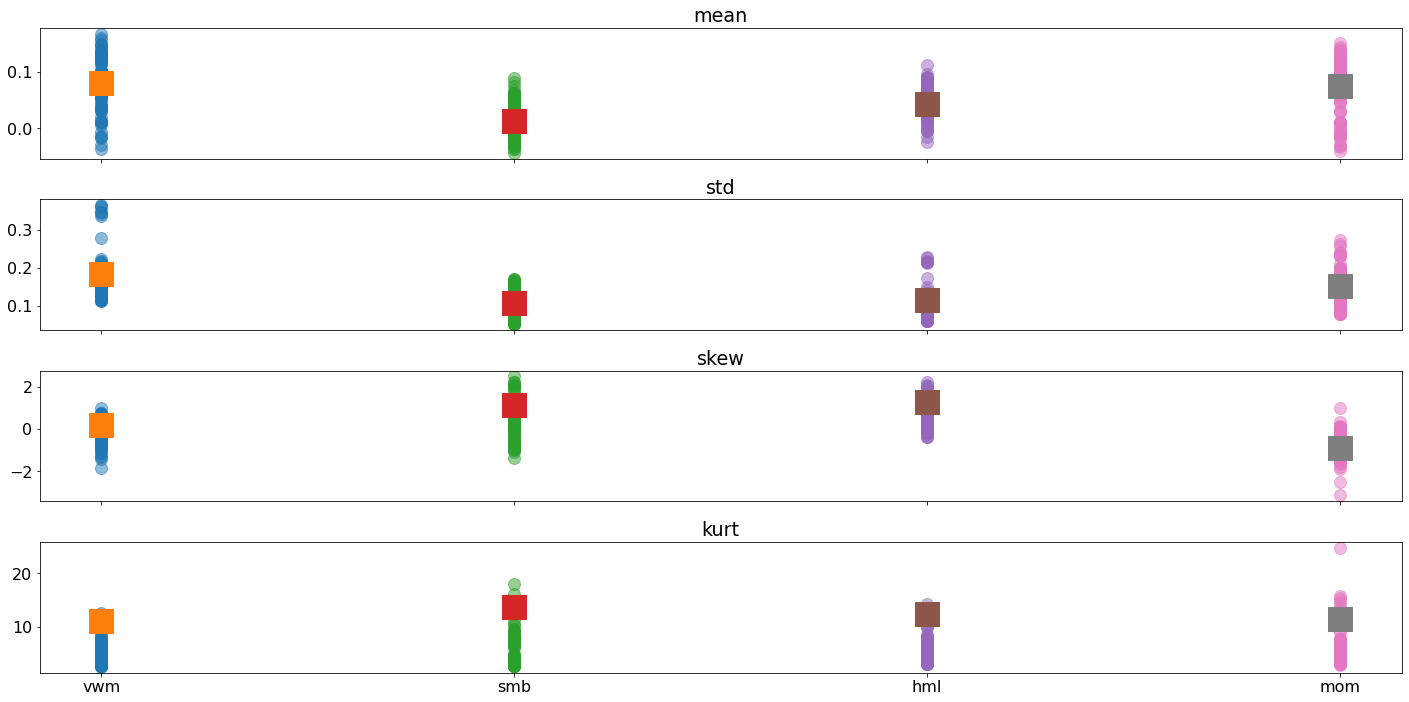

In [12]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=16)


def plot_monthly(series, all_decades=False):
    decade_stats = {}
    full = {}
    for col in series:
        data = combined[col].dropna()
        first = (data.index[0].year // 10 + 1) * 10
        last = (data.index[-1].year // 10 + 1) * 10
        if all_decades:
            first = data.index[0].year
            decades = np.arange(first, 2011, 1)
        else:
            decades = np.arange(first, 2020, 10)
        decade_stats[col] = monthly_stats(data, decades)
        full[col] = summary_statistics(data)["Monthly"]
    fig, ax = plt.subplots(4, 1)
    for i, col in enumerate(decade_stats):
        for j, stat in enumerate(decade_stats[col].index):
            this_stat = decade_stats[col].loc[stat]
            x = i * np.ones_like(this_stat)
            ax[j].plot(x, this_stat, linewidth=0, marker="o", markersize=12, alpha=0.5)
            ax[j].plot(i, full[col].loc[stat], linewidth=0, marker="s", markersize=24)
            ax[j].set_title(stat)
    for j in range(len(decade_stats[col].index)):
        ax[j].set_xticks(np.arange(len(decade_stats)))
        if j < (len(decade_stats) - 1):
            ax[j].set_xticklabels([])
        else:
            ax[j].set_xticklabels(list(decade_stats.keys()))
    fig.tight_layout(pad=1.0)


plot_monthly(["vwm", "smb", "hml", "mom"], all_decades=True)

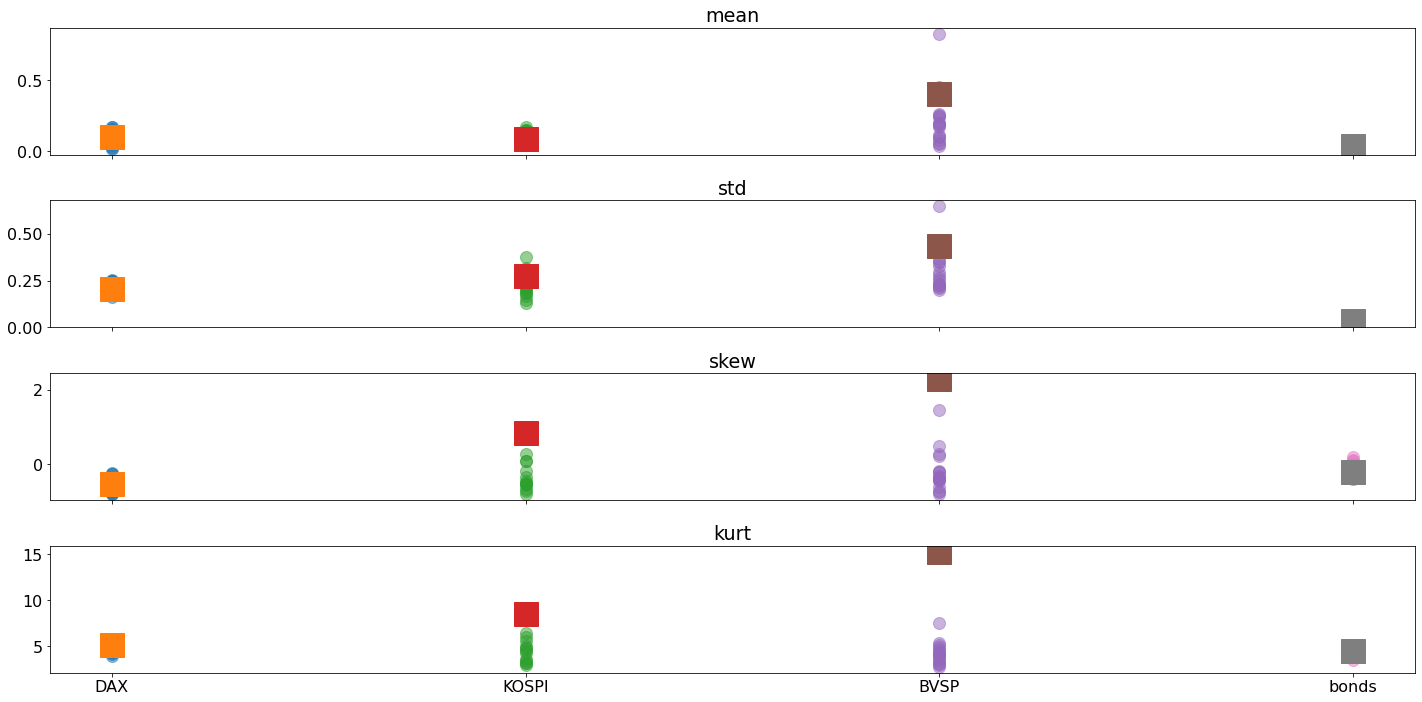

In [13]:
plot_monthly(["DAX", "KOSPI", "BVSP", "bonds"], all_decades=True)

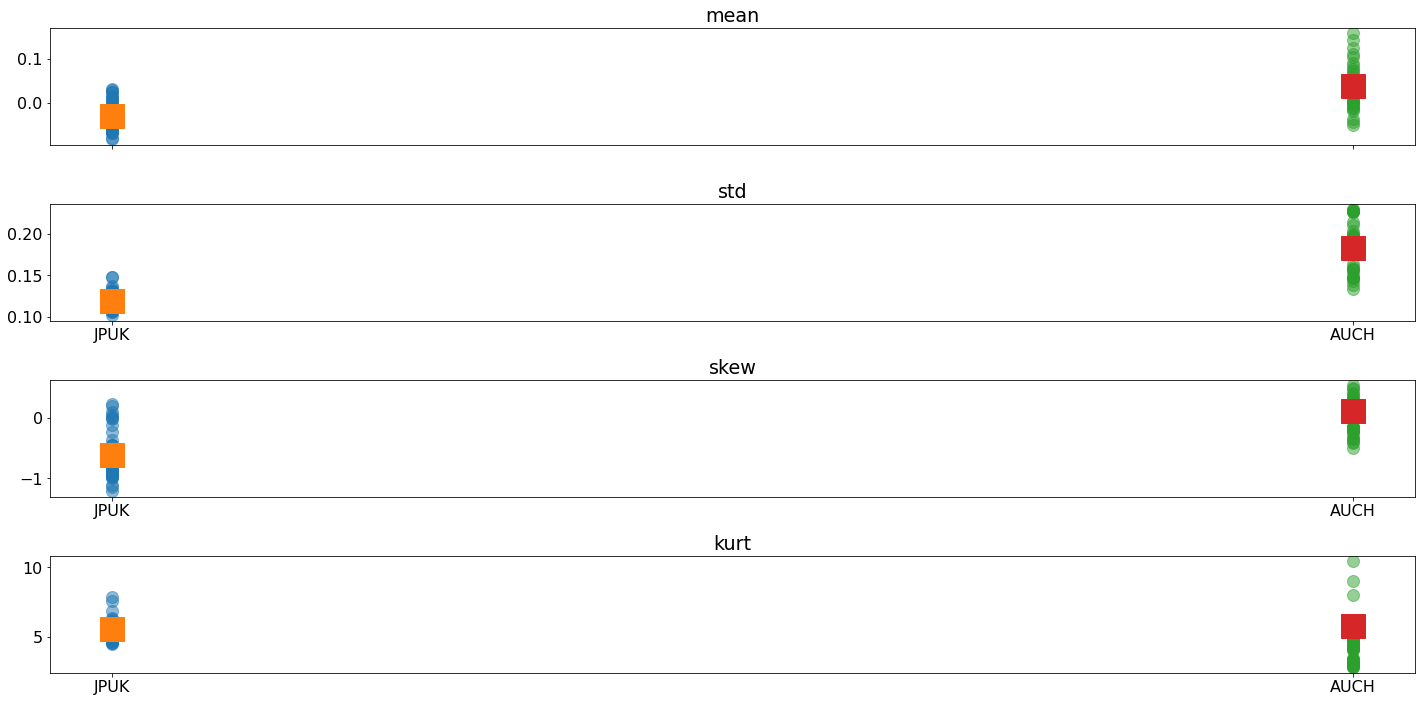

In [14]:
plot_monthly(["JPUK", "AUCH"], all_decades=True)

Finally I compute the DoF for all frequencies using both the MLE and the correct moment-based estimator,

$$
\hat{\nu}_{\text{Mom}} = \frac{4\kappa-6}{\kappa-3}, \kappa > 3
$$

The MLE uses the same approach as in the companion course.

In [15]:
from scipy.special import gammaln
from scipy.optimize import minimize

def std_t_loglik(nu, x):
    # These are fixed for now
    mu = 0
    sigma2 = 1
    sigma = np.sqrt(sigma2)

    a = gammaln((nu + 1) / 2)
    b = gammaln(nu / 2)
    c = np.sqrt(np.pi * (nu - 2))
    d = (nu + 1) / 2
    e = (x - mu) ** 2
    f = sigma2 * (nu - 2)

    loglik = a - b - np.log(c) - np.log(sigma) - d * np.log(1 + e / f)
    return -(loglik.sum())


def moment_nu(rets):
    kappa = rets.kurtosis() + 3
    if kappa <= 3:
        return float(np.inf)
    return float((4 * kappa - 6) / (kappa - 3))


The DoF values are computed from the functions and then stored in a dictionary. The key to the dictionary is a 2-element tuple of the form `(column, frequency)` which pandas automatically converts to a `MultiIndex`.  This simplifies conversion later.

In [16]:
dof = {}
for col in combined:
    for freq in ("D", "W-FRI", "M", "Q", "A"):
        key = (col, freq)
        rets = (
            combined[col].dropna().resample(freq).last().dropna().pct_change().dropna()
        )
        std_rets = (rets - rets.mean()) / rets.std()
        starting_val = np.array([10])
        opt = minimize(
            std_t_loglik,
            starting_val,
            args=(std_rets,),
            bounds=[(2.05, 100)],
            options={"disp": False},
        )
        dof[key] = [float(np.squeeze(opt.x)), moment_nu(rets)]
dof = pd.DataFrame(dof, index=["MLE", "Moment"]).T

dof.head(15)

MLE      Moment
vwm D        2.903435    4.360708
    W-FRI    3.635643    4.974545
    M        3.840701    4.750271
    Q        3.200565    4.350212
    A      100.000000  128.124517
smb D        2.977160    4.264423
    W-FRI    3.616538    4.590585
    M        4.217550    4.560873
    Q        5.539519    4.814348
    A        5.718195    8.567907
hml D        2.902944    4.380508
    W-FRI    3.071014    4.454873
    M        3.336994    4.638080
    Q        3.444944    4.656433
    A       21.478546   14.643151

### Unstacking the values
We can select the `MLE` values and then use unstack to transform a 2-level `MultiIndex` in the a rectangualr table. This will use the "outer" index value (column) as the new index, and the "inner" column values as the column 

In [17]:
mle = dof.MLE.unstack()[["D","W-FRI","M","Q","A"]]
mle

,D,W-FRI,M,Q,A
AUCH,3.719821,4.557508,5.020495,15.669813,100.000000
BVSP,3.451807,3.599981,2.847346,2.271698,2.152317
DAX,3.747828,5.061805,5.147151,4.146419,100.000000
JPUK,3.560871,3.955905,4.818283,7.060872,9.413998
KOSPI,2.937987,3.267547,3.453366,2.790256,52.871615
bonds,7.227888,7.952128,6.508588,100.000000,100.000000
hml,2.902944,3.071014,3.336994,3.444944,21.478546
mom,2.760501,2.979109,3.077491,3.297278,4.223921
rf,11.266749,11.072139,11.545661,13.062032,13.279122
smb,2.977160,3.616538,4.217550,5.539519,5.718195


### Plotting
We can plot them by frequency to see if there is any obvious pattern.

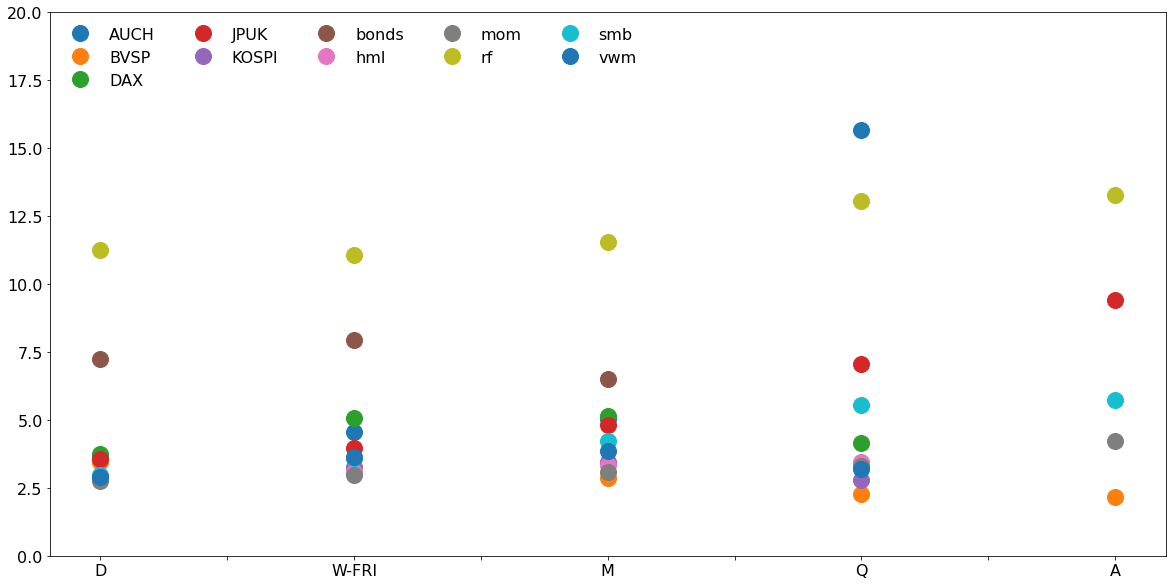

In [21]:
ax = mle.T.plot(legend=False,marker="o",markersize=16,linewidth=0)
ax.set_ylim(0,20)
_ = ax.legend(frameon=False,ncol=5)

In [19]:
moment = dof.Moment.unstack()[["D","W-FRI","M","Q","A"]]
moment

,D,W-FRI,M,Q,A
AUCH,4.330633,4.990076,6.139751,22.852496,inf
BVSP,4.406266,5.327224,4.487519,4.230676,4.254786
DAX,5.034928,5.546289,6.850834,7.385049,inf
JPUK,4.521510,4.675898,6.321226,6.644074,10.693645
KOSPI,5.018194,5.186305,5.077688,4.929423,20.200356
bonds,8.386499,9.411206,8.015244,inf,351.813073
hml,4.380508,4.454873,4.638080,4.656433,14.643151
mom,4.223291,4.479147,4.712752,4.937449,6.322919
rf,8.329772,8.207837,8.402670,9.617265,9.434982
smb,4.264423,4.590585,4.560873,4.814348,8.567907


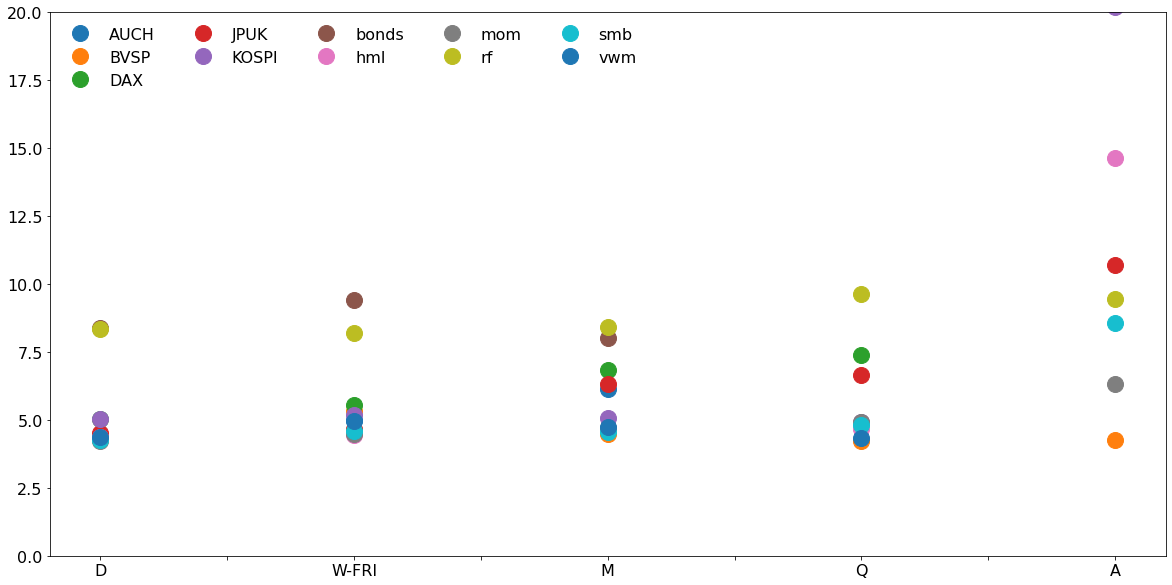

In [22]:
ax = moment.T.plot(legend=False,marker="o",markersize=16,linewidth=0)
ax.set_ylim(0,20)
_ = ax.legend(frameon=False,ncol=5,loc=2)